In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip '/content/drive/MyDrive/assignment/synth_word_texts.zip'

Streaming output truncated to the last 5000 lines.
  inflating: synth_word_texts/word_5499.png  
  inflating: synth_word_texts/word_55.png  
  inflating: synth_word_texts/word_550.png  
  inflating: synth_word_texts/word_5500.png  
  inflating: synth_word_texts/word_5501.png  
  inflating: synth_word_texts/word_5502.png  
  inflating: synth_word_texts/word_5503.png  
  inflating: synth_word_texts/word_5504.png  
  inflating: synth_word_texts/word_5505.png  
  inflating: synth_word_texts/word_5506.png  
  inflating: synth_word_texts/word_5507.png  
  inflating: synth_word_texts/word_5508.png  
  inflating: synth_word_texts/word_5509.png  
  inflating: synth_word_texts/word_551.png  
  inflating: synth_word_texts/word_5510.png  
  inflating: synth_word_texts/word_5511.png  
  inflating: synth_word_texts/word_5512.png  
  inflating: synth_word_texts/word_5513.png  
  inflating: synth_word_texts/word_5514.png  
  inflating: synth_word_texts/word_5515.png  
  inflating: synth_word_texts/wor

In [8]:
!unzip '/content/drive/MyDrive/assignment/icdar_word_texts.zip'

Archive:  /content/drive/MyDrive/assignment/icdar_word_texts.zip
  inflating: icdar_word_texts/coords.txt  
  inflating: icdar_word_texts/gt.txt  
 extracting: icdar_word_texts/word_1.png  
 extracting: icdar_word_texts/word_10.png  
 extracting: icdar_word_texts/word_100.png  
 extracting: icdar_word_texts/word_1000.png  
 extracting: icdar_word_texts/word_1001.png  
 extracting: icdar_word_texts/word_1002.png  
 extracting: icdar_word_texts/word_1003.png  
 extracting: icdar_word_texts/word_1004.png  
 extracting: icdar_word_texts/word_1005.png  
 extracting: icdar_word_texts/word_1006.png  
 extracting: icdar_word_texts/word_1007.png  
 extracting: icdar_word_texts/word_1008.png  
 extracting: icdar_word_texts/word_1009.png  
 extracting: icdar_word_texts/word_101.png  
 extracting: icdar_word_texts/word_1010.png  
 extracting: icdar_word_texts/word_1011.png  
 extracting: icdar_word_texts/word_1012.png  
 extracting: icdar_word_texts/word_1013.png  
 extracting: icdar_word_texts/wo

In [28]:
# Imports

import numpy as np
import pandas as pd
import os
import scipy.io
import glob
from tqdm import tqdm 
import random
import pickle
import cv2
import time
import scipy.optimize
from shapely.geometry import Polygon
import math
import traceback
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math
import pydot
import traceback
try:
    import queue
except ImportError:
    import Queue as queue
import warnings
warnings.filterwarnings("ignore")

As we will be doing the recognition pipeline along with detection, here we will only create and train the model. But we will predict the results along with detection.

Here the loss term and generator function are small and there is no reusability, so we can define both of them here itself unlike detection training notebook.

Again we have around 40k images. So we can make use of validation data.

In [29]:
# Load the df
data = pd.read_csv('text_word_df.csv',index_col=0)
print(data.head())
train,test=train_test_split(data,test_size=0.15,random_state=42)

                          path word
0  synth_word_texts/word_1.png  for
1  synth_word_texts/word_2.png  and
2  synth_word_texts/word_3.png  and
3  synth_word_texts/word_4.png  the
4  synth_word_texts/word_5.png  FOR


In [30]:
# Build vocab
CHARS = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZÉ´-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
NUM_CLASSES = len(CHARS) 
char_to_index={}
index_to_char={}
for i,char in enumerate(CHARS):
  index_to_char[i+1]=char
  char_to_index[char]=i+1

In [31]:
# Generator for recognition training
def generator(data, batch_size):
  """Generator function to produce input image and coresponding text vector"""
  while True:
    images = []
    texts_vec = []
    for i in range(data.shape[0]):
      try:
        path = data.iloc[i]['path']
        # Load image and save image matrix
        img = cv2.imread(path)
        img = cv2.detailEnhance(img)
        img = cv2.resize(img, (128,64),cv2.INTER_NEAREST)
        text = str(data.iloc[i]['word'])
        if len(text)==0:
          continue
        images.append(img)
        # Convert the text to vector
        text_vec = []
        for char in text:
          text_vec.append(char_to_index[char])
        # Maintaining constant size  
        while len(text_vec) < 25:
            text_vec.append(0)
        text_vec = np.array(text_vec)
        texts_vec.append(text_vec)
        if len(images) == batch_size:
          yield (np.array(images),np.array(texts_vec))
          images=[]
          texts_vec=[]
      except Exception as e:
        print('Error for: ', path)
        traceback.print_exc()
        continue  

In [32]:
# Loss for recognition training
# https://stackoverflow.com/questions/64321779/how-to-use-tf-ctc-loss-with-variable-length-features-and-labels
def ctc_loss(y_true,y_pred):
  label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
  return tf.keras.backend.ctc_batch_cost(y_true, y_pred, np.ones((128,1),'int32')*64, label_length)

In [33]:
# Recognition Model

input = tf.keras.layers.Input(name ='input', shape = (64,128,3), dtype='float32')

x = tf.keras.layers.Conv2D(64, (3, 3), padding ='same', activation = 'relu', name ='conv1', kernel_initializer = 'he_normal')(input) 
x = tf.keras.layers.Conv2D(64, (3, 3), padding ='same', activation = 'relu', name ='conv2', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 1), name = 'max-pool1')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), padding ='same', activation = 'relu', name ='conv3', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.Conv2D(128, (3, 3), padding ='same', activation = 'relu', name ='conv4', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 1), name = 'max-pool2')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding ='same', activation = 'relu', name ='conv5', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.Conv2D(256, (3, 3), padding ='same', activation = 'relu', name ='conv6', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 1), name = 'max-pool3')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(target_shape= ((256,-1)), name='reshape')(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256,return_sequences=True))(x)
x = x=tf.keras.layers.Dense(NUM_CLASSES+2)(x)
out = tf.keras.activations.softmax(x)

recognizer=tf.keras.models.Model(input, out)
recognizer.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 128, 3)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 128, 64)       1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 128, 64)       36928     
_________________________________________________________________
max-pool1 (MaxPooling2D)     (None, 32, 128, 64)       0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 128, 64)       256       
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 128, 128)      73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 128, 128)      1475

In [34]:
recognizer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),loss=ctc_loss)

In [35]:
# Callbacks
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,mode='min',factor=0.75,verbose=1)
early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min',verbose=1)
save=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/assignment/recoginzer.h5',monitor='val_loss',mode='min')

In [36]:
history = recognizer.fit(generator(train, 128),epochs=50,steps_per_epoch=train.shape[0]//128,
               validation_data=generator(test, 128),validation_steps=test.shape[0]//128,
               callbacks=[reduce_lr,early,save])

Epoch 1/50
268/268 [==============================] - 342s 1s/step - loss: 18.3558 - val_loss: 15.6241
Epoch 2/50
268/268 [==============================] - 337s 1s/step - loss: 14.9006 - val_loss: 15.0561
Epoch 3/50
268/268 [==============================] - 337s 1s/step - loss: 13.7660 - val_loss: 13.6629
Epoch 4/50
268/268 [==============================] - 337s 1s/step - loss: 12.6896 - val_loss: 12.7813
Epoch 5/50
268/268 [==============================] - 337s 1s/step - loss: 11.7132 - val_loss: 12.0653
Epoch 6/50
268/268 [==============================] - 336s 1s/step - loss: 10.0477 - val_loss: 11.4753
Epoch 8/50
268/268 [==============================] - 337s 1s/step - loss: 9.4148 - val_loss: 11.2922
Epoch 9/50
268/268 [==============================] - 337s 1s/step - loss: 8.9196 - val_loss: 11.4228
Epoch 10/50
268/268 [==============================] - 337s 1s/step - loss: 8.4375 - val_loss: 11.3839

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.000750000035623

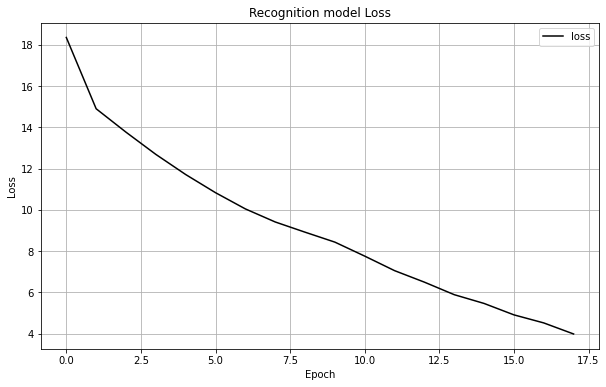

In [38]:
# Plot epoch-loss for recognition model

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],color='black')
plt.title('Recognition model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper right')
plt.grid()
plt.savefig('recognition_loss.png', dpi=480, bbox_inches='tight')
plt.show()

In [39]:
# Save the weights
recognizer.save_weights('/content/drive/MyDrive/assignment/recoginzer.h5')